# Análisis de vuelos
_____

# EDA

In [40]:
mapeo_nombres = {
        'FO': 'Flybondi',
        'WJ': 'Jetsmart'
    }

# 2. Diccionario de Colores Fijos
# Esto asegura que Empresa Alfa siempre sea Azul, no importa el orden
colores_fijos = {
    'Jetsmart': '#1b365d', # Azul
    'Flybondi': '#fdbe15'  # Naranja
}

In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

def cargar_datos(ruta_archivo, **kwargs):
    """
    Carga un archivo CSV o Parquet y devuelve un DataFrame de Pandas.

    :param ruta_archivo: str, camino al archivo.
    :param kwargs: Argumentos adicionales para pd.read_csv o pd.read_parquet.
    :return: pd.DataFrame
    """
    # Extraemos la extensión del archivo
    _, extension = os.path.splitext(ruta_archivo)
    extension = extension.lower()

    try:
        if extension == '.csv':
            return pd.read_csv(ruta_archivo, **kwargs)
        elif extension == '.parquet':
            return pd.read_parquet(ruta_archivo, **kwargs)
        else:
            raise ValueError(f"Formato no soportado: {extension}. Solo CSV o Parquet.")

    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None

def graficar_frecuencias(df, columna, categoria=None, titulo=None, color='deeppink', ordenar_por_indice=False):
    """
    Genera un gráfico de barras.
    Permite ordenar el eje X por nombre o por frecuencia total,
    manteniendo la comparación por categoría.
    """
    plt.figure(figsize=(10, 6))
    df_plot = df.copy()
    df_plot['empresa'] = df_plot['empresa'].map(mapeo_nombres).fillna(df_plot['empresa'])
    # 1. Definir el orden del eje X
    if ordenar_por_indice:
        # Orden alfabético/numérico (ej: Enero, Febrero, Marzo)
        # valores_unicos = pd.to_numeric(df[columna], errors='coerce').unique()
        order = sorted(df_plot[columna].unique())
    else:
        # Orden por frecuencia TOTAL (la barra más alta primero)
        # Esto asegura que el orden sea consistente incluso con 'hue'
        order = df_plot[columna].value_counts().index.astype(str)

    # 2. Creación del gráfico
    if categoria:
        # El parámetro 'hue' crea la comparación por categorías
        sns.countplot(data=df_plot, x=columna, hue=categoria, order=order, palette=colores_fijos)
        plt.legend(title=categoria, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # Si no hay categoría, usamos un gráfico simple con el orden definido
        sns.countplot(data=df_plot, x=columna, order=order, color=color)

    # 3. Estética
    plt.title(titulo if titulo else f'Distribución de {columna}' + (f' por {categoria}' if categoria else ''), fontsize=14)
    plt.xlabel(columna, fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [42]:
df = cargar_datos("vuelos_historicos_consolidado.parquet")
df.head(5)

,Vuelo,Ruta,Hora Programada,Hora Real,Demora en despegar,fecha,mes,empresa,minutos_netos_demora,status,is_cancelled,franja_horaria,nivel_demora
0,WJ 3169,Aeroparque → Neuquen,2026-02-05 18:29:00,00:55 +1,6hs 26min tarde,2025-01-01,1,WJ,386.0,Delayed,False,18,Crítico (>3h)
1,WJ 3142,Aeroparque → Iguazú,2026-02-05 19:20:00,22:25,3hs 5min tarde,2025-01-01,1,WJ,185.0,Delayed,False,19,Crítico (>3h)
2,WJ 3145,Iguazú → Ezeiza,2026-02-05 21:41:00,00:38 +1,2hs 57min tarde,2025-01-01,1,WJ,177.0,Delayed,False,21,Demora Grave (45m-3h)
3,WJ 3165,Aeroparque → Neuquen,2026-02-05 16:40:00,18:46,2hs 6min tarde,2025-01-01,1,WJ,126.0,Delayed,False,16,Demora Grave (45m-3h)
4,WJ 3820,Aeroparque → Florianopolis,2026-02-05 16:55:00,18:56,2hs 1min tarde,2025-01-01,1,WJ,121.0,Delayed,False,16,Demora Grave (45m-3h)


In [43]:
df.dtypes

,0
Vuelo,object
Ruta,object
Hora Programada,datetime64[ns]
Hora Real,object
Demora en despegar,object
fecha,object
mes,int64
empresa,object
minutos_netos_demora,float64
status,object


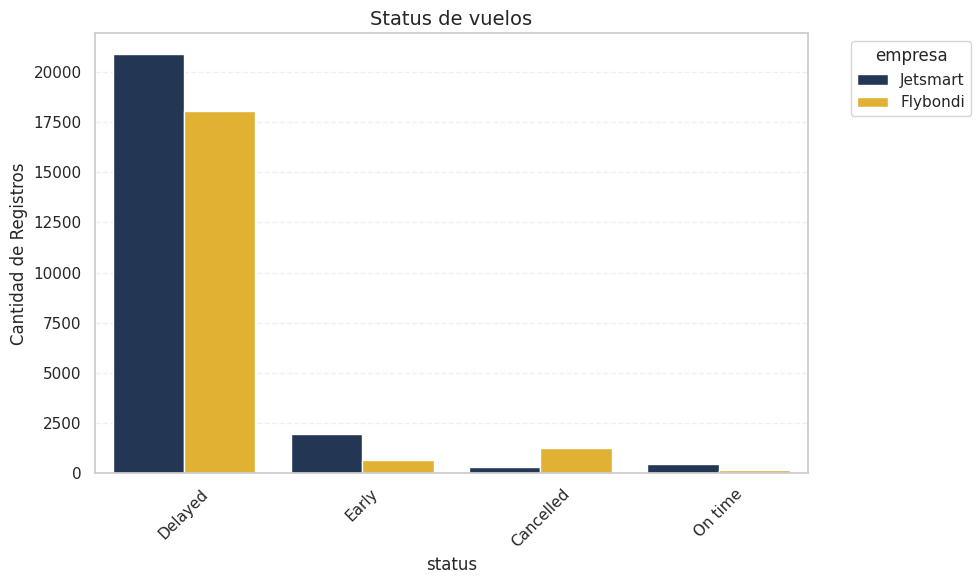

In [44]:
graficar_frecuencias(df, 'status', categoria="empresa", titulo='Status de vuelos', color='skyblue')

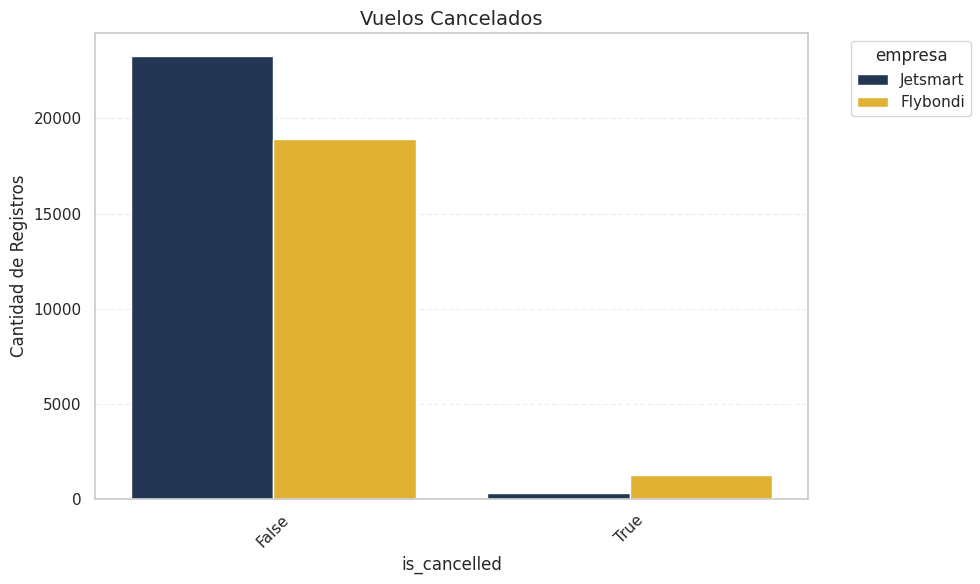

In [45]:
graficar_frecuencias(df, 'is_cancelled', categoria="empresa", titulo='Vuelos Cancelados')


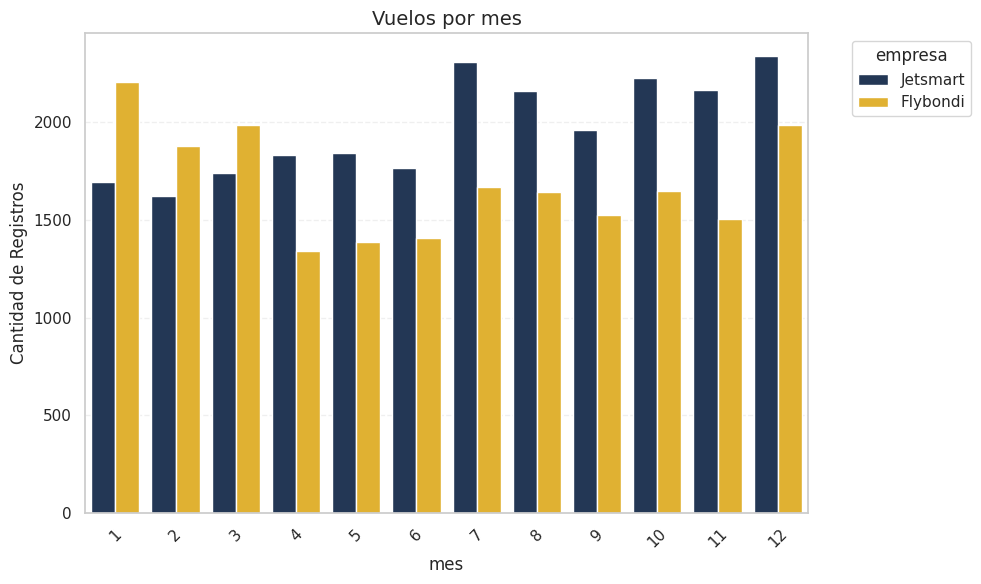

In [46]:
graficar_frecuencias(df, 'mes', categoria="empresa", titulo='Vuelos por mes', color="lime", ordenar_por_indice=True)

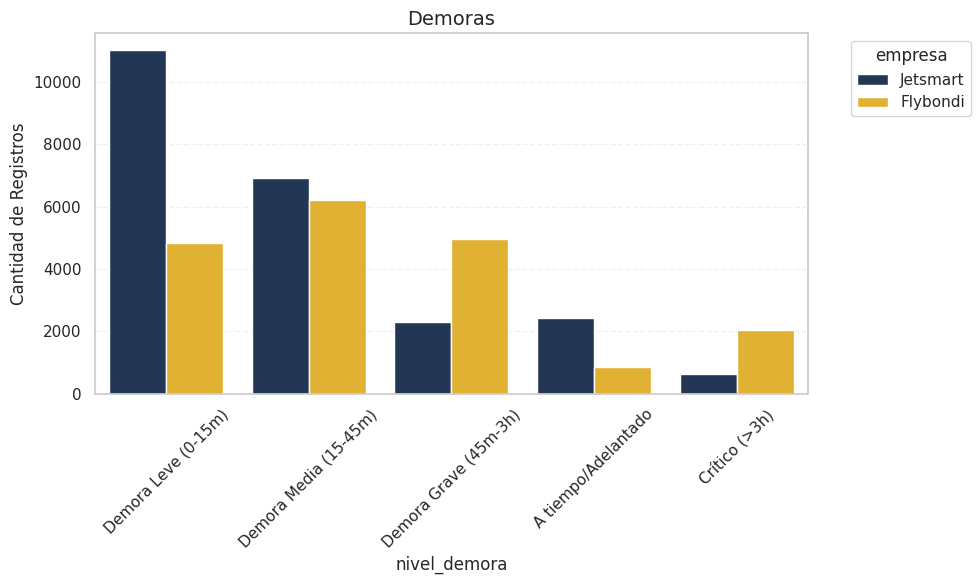

In [47]:
graficar_frecuencias(df, 'nivel_demora', categoria="empresa", titulo='Demoras', color="skyblue")

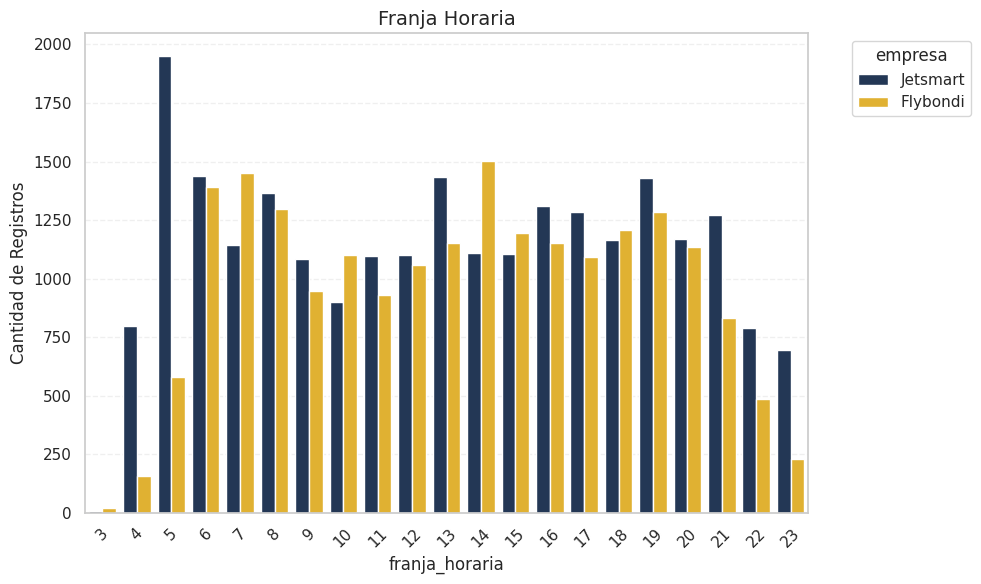

In [48]:
graficar_frecuencias(df, 'franja_horaria', categoria="empresa", titulo='Franja Horaria', color="lime", ordenar_por_indice=True)

In [49]:
resumen = {
    'Promedio de demora': df['minutos_netos_demora'].mean(),
    'Mediana (el valor real típico)': df['minutos_netos_demora'].median(),
    'Vuelo más demorado': df['minutos_netos_demora'].max(),
    'Total de vuelos cancelados': df['minutos_netos_demora'].isna().sum()
}
print(resumen)

{'Promedio de demora': np.float64(47.22485964039514), 'Mediana (el valor real típico)': 18.0, 'Vuelo más demorado': 1349.0, 'Total de vuelos cancelados': np.int64(1618)}


In [53]:
def graficar_evolucion(df, x, y, categoria=None, estimador='mean', titulo=None):
    """
    Grafica la evolución de una métrica con nombres reales y colores fijos.
    """

    # 2. Preparación de datos (Copia para no alterar el original)
    df_plot = df.copy()
    if categoria:
        df_plot[categoria] = df_plot[categoria].map(mapeo_nombres).fillna(df_plot[categoria])

    plt.figure(figsize=(12, 5))
    sns.set_theme(style="whitegrid")

    # 3. Creación del gráfico
    # Pasamos 'colores_fijos' al parámetro 'palette'
    plot = sns.lineplot(
        data=df_plot,
        x=x,
        y=y,
        hue=categoria,
        estimator=estimador,
        marker='o',
        linewidth=2.5,
        errorbar=None,
        palette=colores_fijos if categoria else None
    )

    # 4. Personalización de etiquetas
    label_y = y.replace('_', ' ').title()
    label_x = x.replace('_', ' ').title()

    plt.title(titulo if titulo else f'{label_y} por {label_x}', fontsize=15, pad=20)
    plt.xlabel(label_x, fontsize=12)
    plt.ylabel(f'{estimador.capitalize()} de {label_y}', fontsize=12)

    if categoria:
        plt.legend(title=categoria.replace('_', ' ').title(),
                   bbox_to_anchor=(1.05, 1), loc='upper left')

    if df_plot[x].dtype in ['int64', 'int32']:
        plt.xticks(sorted(df_plot[x].unique()))

    plt.tight_layout()
    plt.show()

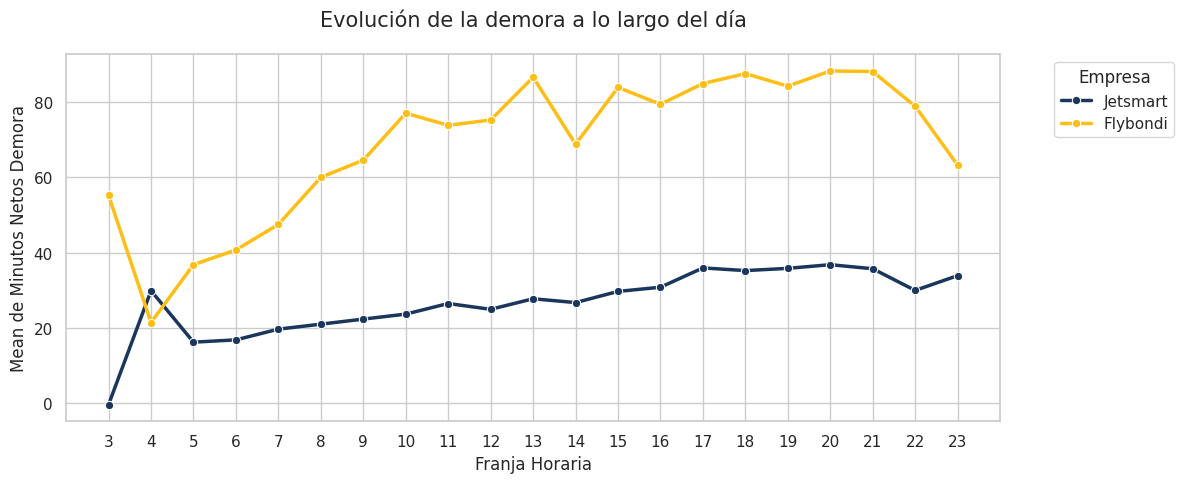

In [54]:
graficar_evolucion(df, 'franja_horaria', 'minutos_netos_demora', categoria="empresa", estimador='mean', titulo='Evolución de la demora a lo largo del día')


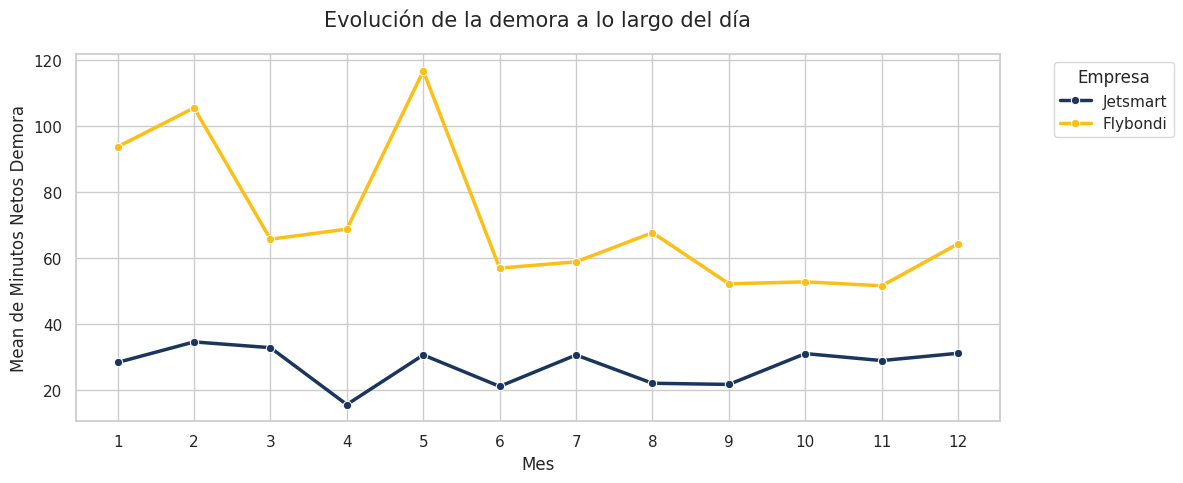

In [55]:
graficar_evolucion(df, 'mes', 'minutos_netos_demora', categoria="empresa", estimador='mean', titulo='Evolución de la demora a lo largo del día')


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def comparar_impacto_y_eficiencia(df):
    """
    Compara el impacto total y la eficiencia (promedio) por empresa.
    """
    # 1. Agrupación y cálculos métricas base
    resumen = df.groupby('empresa').agg(
        minutos_totales=('minutos_netos_demora', 'sum'),
        demora_promedio=('minutos_netos_demora', 'mean'),
        total_operaciones=('minutos_netos_demora', 'count')
    ).reset_index()

    # 2. Conversiones de tiempo
    resumen['dias_totales'] = resumen['minutos_totales'] / 1440

    # 3. Presentación en consola mejorada
    print(f"{'EMPRESA':<20} | {'OPS':<8} | {'DÍAS TOTALES':<15} | {'PROM. MIN/VIAJE':<15}")
    print("-" * 65)

    for _, fila in resumen.sort_values('demora_promedio', ascending=False).iterrows():
        print(f"{fila['empresa']:<20} | "
              f"{fila['total_operaciones']:>8,.0f} | "
              f"{fila['dias_totales']:>15,.2f} | "
              f"{fila['demora_promedio']:>15,.2f}")

    # 4. Visualización Doble (Impacto vs Eficiencia)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico 1: Impacto Total (Magnitud)
    sns.barplot(data=resumen, x='empresa', y='dias_totales', ax=ax[0], palette='magma')
    ax[0].set_title('Impacto Total (Días de espera)', fontsize=12)
    ax[0].set_ylabel('Días')

    # Gráfico 2: Eficiencia Relativa (Calidad del servicio)
    sns.barplot(data=resumen, x='empresa', y='demora_promedio', ax=ax[1], palette='viridis')
    ax[1].set_title('Eficiencia Relativa (Promedio Minutos/Viaje)', fontsize=12)
    ax[1].set_ylabel('Minutos por Operación')

    # Añadir línea de promedio global para referencia
    promedio_global = df['minutos_netos_demora'].mean()
    ax[1].axhline(promedio_global, color='red', linestyle='--', label=f'Promedio Global: {promedio_global:.1f}')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    return resumen

EMPRESA              | OPS      | DÍAS TOTALES    | PROM. MIN/VIAJE
-----------------------------------------------------------------
FO                   |   18,908 |          939.68 |           71.56
WJ                   |   23,305 |          444.70 |           27.48


/tmp/ipython-input-4105594192.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumen, x='empresa', y='dias_totales', ax=ax[0], palette='magma')
/tmp/ipython-input-4105594192.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumen, x='empresa', y='demora_promedio', ax=ax[1], palette='viridis')


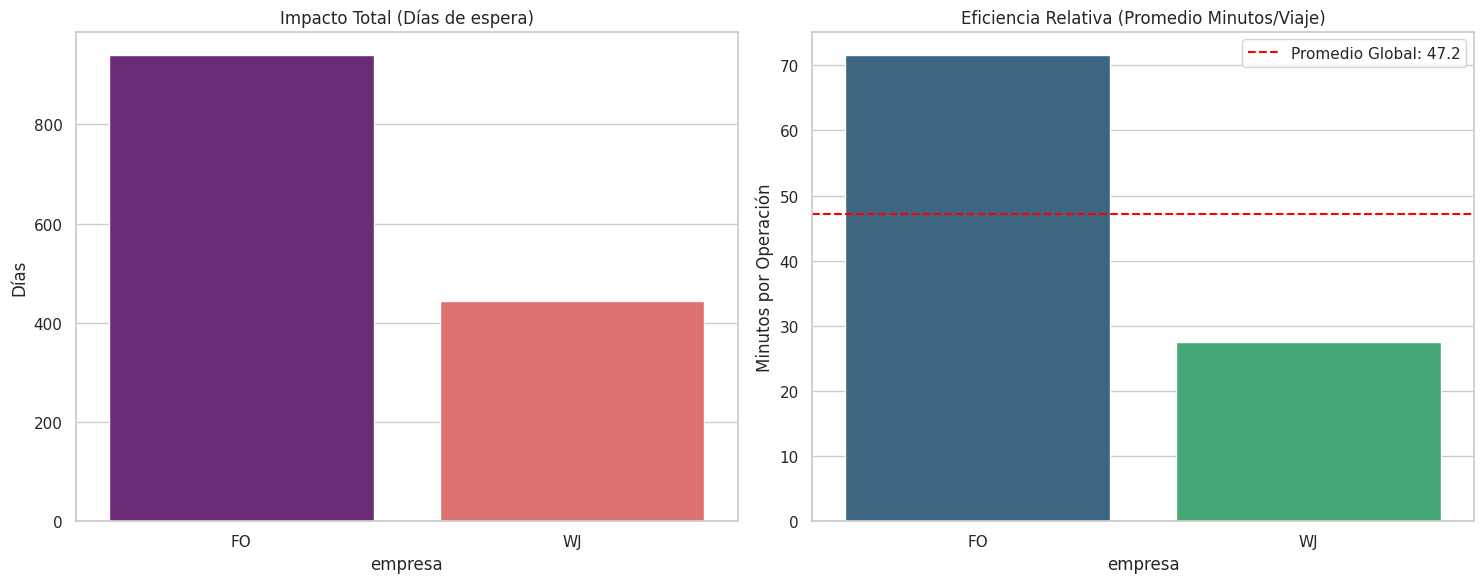

,empresa,minutos_totales,demora_promedio,total_operaciones,dias_totales
0,FO,1353137.0,71.564259,18908,939.678472
1,WJ,640366.0,27.477623,23305,444.698611


In [19]:
comparar_impacto_y_eficiencia(df)

In [20]:
# 1. Sumamos todos los minutos de demora (ignorando los NaN automáticamente)
total_minutos = df['minutos_netos_demora'].sum()

# 2. Conversiones
total_horas = total_minutos / 60
total_dias = total_minutos / 1440 # 1440 min tiene un día

print(f"--- IMPACTO TOTAL DE LAS DEMORAS ---")
print(f"Tiempo total perdido: {total_minutos:,.0f} minutos")
print(f"Equivalente a: {total_horas:,.1f} horas")
print(f"Equivalente a: {total_dias:,.2f} días completos de espera")

total_anios = total_dias / 365
if total_anios > 1:
  print(f"Equivalente a: {total_anios:,.2f} años completos de espera")


--- IMPACTO TOTAL DE LAS DEMORAS ---
Tiempo total perdido: 1,993,503 minutos
Equivalente a: 33,225.1 horas
Equivalente a: 1,384.38 días completos de espera
Equivalente a: 3.79 años completos de espera


In [22]:
def graficar_impacto_temporal(df, unidad='dias', mostrar_etiquetas=False):
    """
    Compara el impacto de demora por mes y empresa.
    :param unidad: 'minutos', 'horas' o 'dias'.
    :param mostrar_etiquetas: bool, si es True muestra el valor sobre cada barra.
    """
    # 1. Configuración de conversión
    config = {
        'minutos': {'divisor': 1, 'label': 'Minutos Totales', 'fmt': '%.0f'},
        'horas':   {'divisor': 60, 'label': 'Horas Totales', 'fmt': '%.1f'},
        'dias':    {'divisor': 1440, 'label': 'Días de Vida Perdidos', 'fmt': '%.2f'}
    }

    if unidad not in config:
        raise ValueError("La unidad debe ser 'minutos', 'horas' o 'dias'")

    # 2. Preparación de datos
    divisor = config[unidad]['divisor']
    label_y = config[unidad]['label']
    formato = config[unidad]['fmt']

    df_agrupado = df.groupby(['mes', 'empresa'])['minutos_netos_demora'].sum().reset_index()
    df_agrupado['valor_convertido'] = df_agrupado['minutos_netos_demora'] / divisor

    # 3. Creación del gráfico
    plt.figure(figsize=(14, 7))
    sns.set_theme(style="whitegrid")

    ax = sns.barplot(
        data=df_agrupado,
        x='mes',
        y='valor_convertido',
        hue='empresa',
        palette='magma'
    )

    # 4. Opción de Data Labels
    if mostrar_etiquetas:
        # Iteramos sobre los contenedores de barras que creó Seaborn
        for container in ax.containers:
            ax.bar_label(container, fmt=formato, padding=3, fontsize=9)

    # 5. Estética
    plt.title(f'Comparativa Mensual: {label_y}', fontsize=15, pad=20)
    plt.ylabel(label_y, fontsize=12)
    plt.xlabel('Mes', fontsize=12)
    plt.legend(title='Empresa', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar margen superior para que las etiquetas no se corten
    plt.margins(y=0.15)
    plt.tight_layout()
    plt.show()

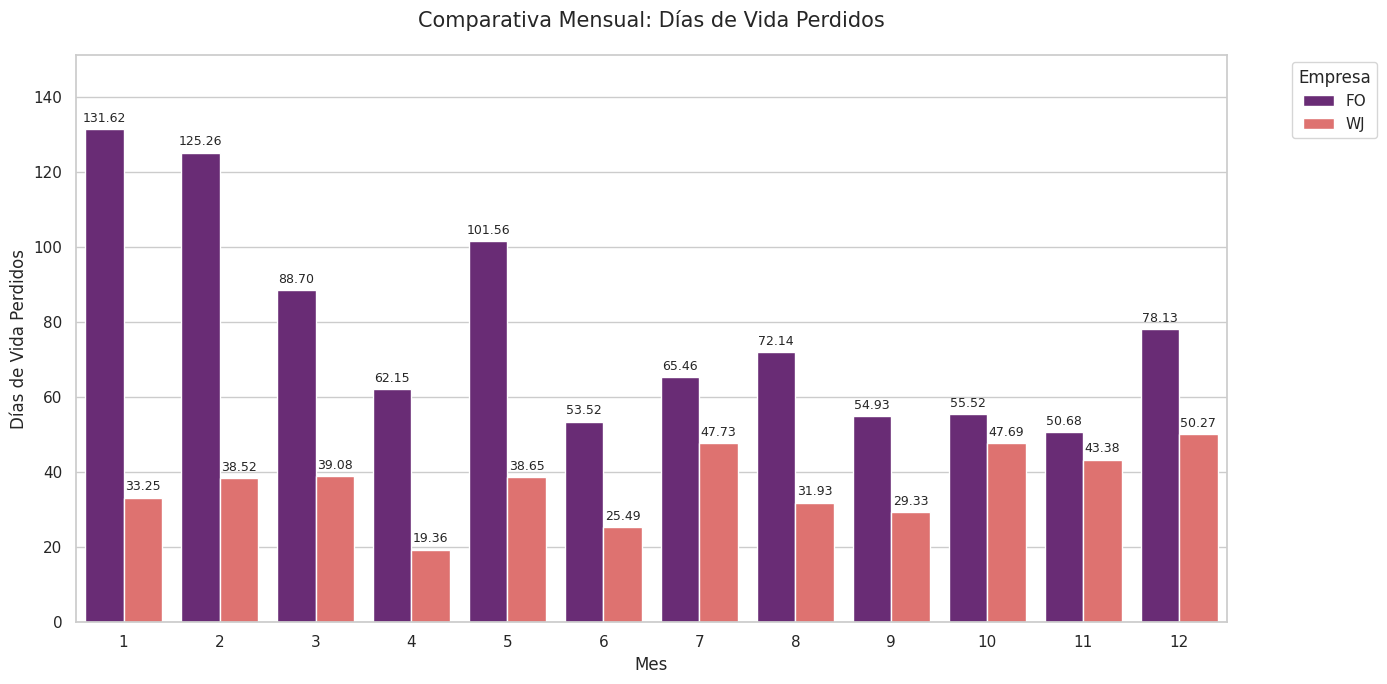

In [25]:
graficar_impacto_temporal(df, unidad='dias', mostrar_etiquetas=True)

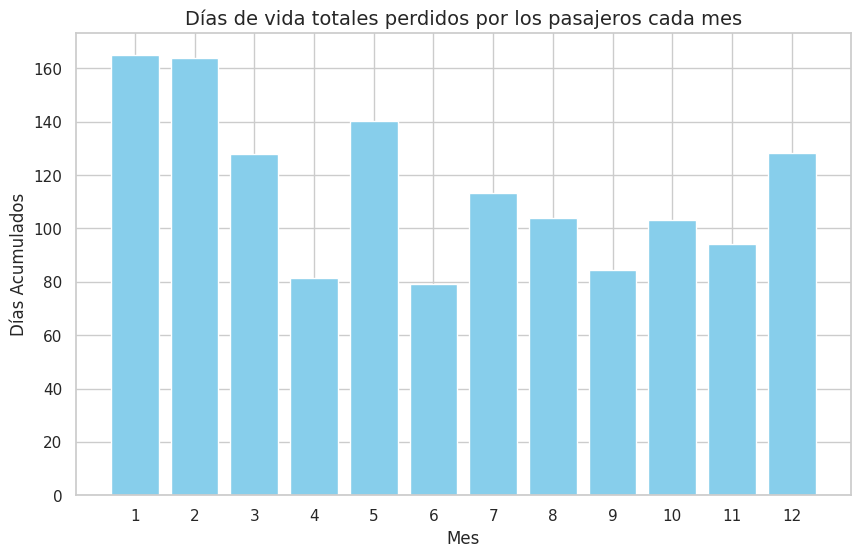

In [23]:
# Agrupamos la suma de minutos por mes y convertimos a días
dias_por_mes = df.groupby('mes')['minutos_netos_demora'].sum() / 1440

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(dias_por_mes.index.astype(str), dias_por_mes.values, color='skyblue')
plt.title('Días de vida totales perdidos por los pasajeros cada mes', fontsize=14)
plt.ylabel('Días Acumulados', fontsize=12)
plt.xlabel('Mes', fontsize=12)
plt.show()